Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**1. Data Reading/Data Understanding**

In [2]:
from zipfile import ZipFile
with ZipFile('drive/MyDrive/CNN_assignment.zip', 'r') as zipobj:
  zipobj.extractall('drive/MyDrive/CNN_assignment')

In [5]:
## Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')
## Ref:https://drive.google.com/file/d/1Dy6A-76u4Aa1Sti40pDpl4qbP2gr1u_v/view?usp=sharing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2416
118


**2. Dataset Creation**

Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
## Create train dataset from the train directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2416 files belonging to 9 classes.
Using 1933 files for training.


In [10]:
## Create validation dataset from the train directory 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2416 files belonging to 9 classes.
Using 483 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**3. Dataset visualisation**

Create a code to visualize one instance of all the nine classes present in the dataset 


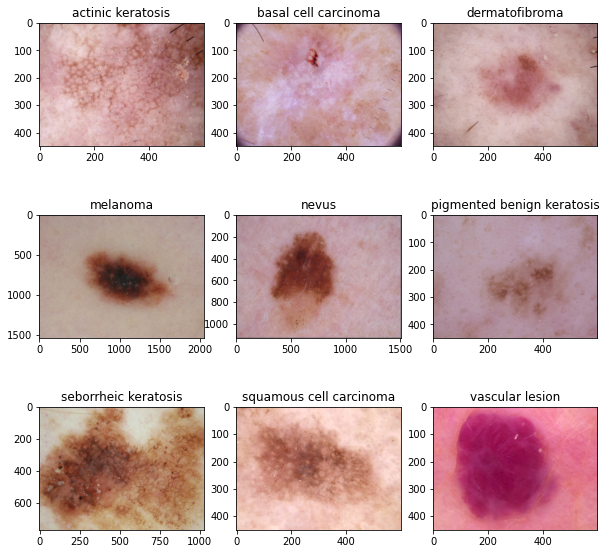

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [13]:
## Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
## Dataset.prefetch() overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**4.Model Building & training**

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).

In [14]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile the model

In [15]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

Train the model

In [17]:
## Train the model for ~20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


61/61 [==============================] - 127s 415ms/step - loss: 2.0592 - accuracy: 0.2188 - val_loss: 2.0171 - val_accuracy: 0.2422
Epoch 2/20
61/61 [==============================] - 5s 76ms/step - loss: 2.0329 - accuracy: 0.2256 - val_loss: 2.0377 - val_accuracy: 0.2360
Epoch 3/20
61/61 [==============================] - 5s 75ms/step - loss: 1.9910 - accuracy: 0.2571 - val_loss: 1.8595 - val_accuracy: 0.3168
Epoch 4/20
61/61 [==============================] - 5s 75ms/step - loss: 1.9967 - accuracy: 0.2633 - val_loss: 2.0431 - val_accuracy: 0.1718
Epoch 5/20
61/61 [==============================] - 5s 75ms/step - loss: 2.0425 - accuracy: 0.2312 - val_loss: 2.0285 - val_accuracy: 0.2422
Epoch 6/20
61/61 [==============================] - 5s 75ms/step - loss: 2.0316 - accuracy: 0.2318 - val_loss: 2.0348 - val_accuracy: 0.2402
Epoch 7/20
61/61 [==============================] - 5s 75ms/step - loss: 2.0305 - accuracy: 0.2307 - val_loss: 2.0313 - val_accuracy: 0.2402
Epoch 8/20
61/61 [===

Findings after the model fit. Check any evidence of model overfit or underfit.

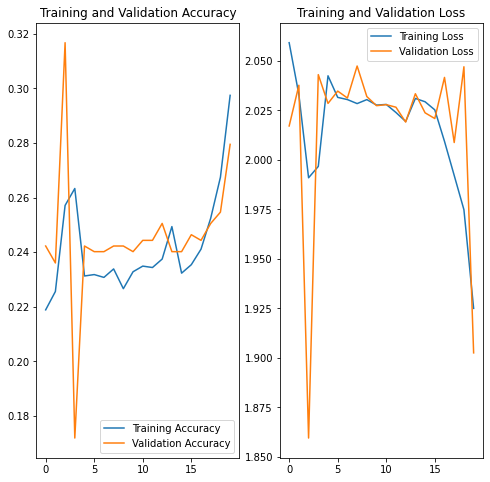

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

****Finding on the first base model****
-  The model is not overfitting but accuracy is very small.

**5. Chose an appropriate data augmentation strategy**

In [19]:
## Choose an appropriate data augumentation strategy
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

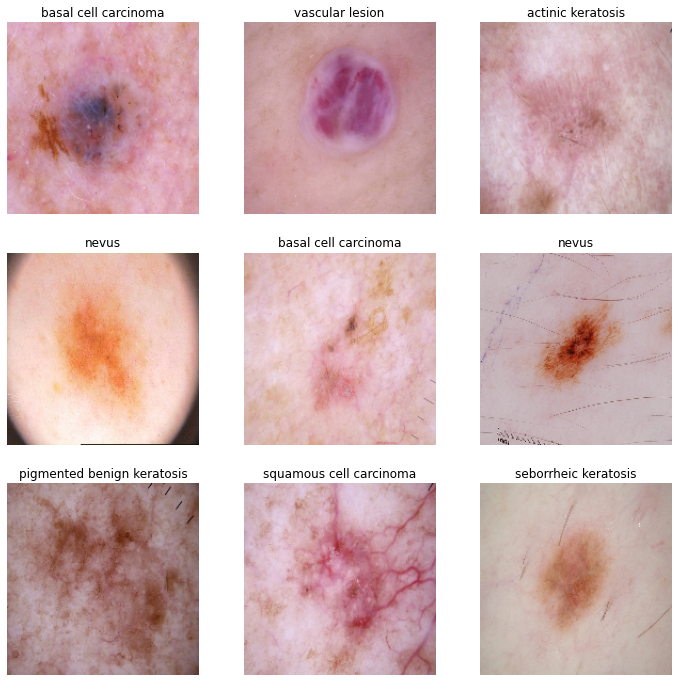

In [20]:
## Visualize the augmentation strategy for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**6. Model Building & training on the augmented data**

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).

In [21]:
## Dropout layer if there is an evidence of overfitting in our findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compiling the model

In [22]:
## Choose an appropriate optimiser and loss function for model training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [23]:
## Train the model for ~20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
61/61 [==============================] - 7s 92ms/step - loss: 2.1235 - accuracy: 0.2240 - val_loss: 2.0507 - val_accuracy: 0.1698
Epoch 2/20
61/61 [==============================] - 5s 85ms/step - loss: 2.0512 - accuracy: 0.2250 - val_loss: 2.0247 - val_accuracy: 0.2422
Epoch 3/20
61/61 [==============================] - 5s 85ms/step - loss: 2.0392 - accuracy: 0.2307 - val_loss: 2.0423 - val_accuracy: 0.2402
Epoch 4/20
61/61 [==============================] - 5s 84ms/step - loss: 2.0301 - accuracy: 0.2307 - val_loss: 2.0273 - val_accuracy: 0.2422
Epoch 6/20
61/61 [==============================] - 5s 84ms/step - loss: 2.0288 - accuracy: 0.2307 - val_loss: 2.0268 - val_accuracy: 0.2402
Epoch 7/20
61/61 [==============================] - 5s 84ms/step - loss: 2.0273 - accuracy: 0.2323 - val_loss: 2.0313 - val_accuracy: 0.2422
Epoch 8/20
61/61 [==============================] - 5s 84ms/step - loss: 2.0272 - accuracy: 0.2312 - val_loss: 2.0258 - val_accuracy: 0.2422
Epoch 9/20
61

****Finding from Second Model****

-  There is no improvement in accuracy.
-  We can increase the epochs to increase the accuracy so it's too early for judgement.


In [24]:
## See the images based on their labels
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
...,...,...
2411,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2412,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2413,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2414,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion


In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
...,...,...
2411,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2412,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2413,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2414,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion


**7. Class distribution**

<BarContainer object of 9 artists>

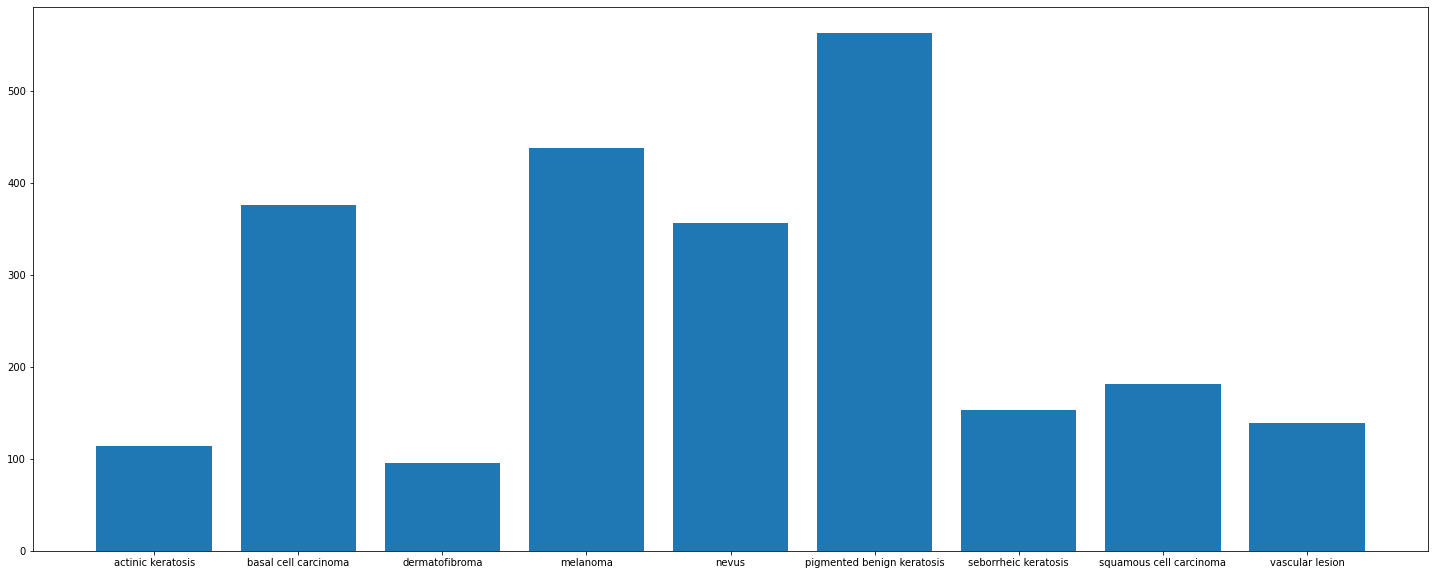

In [26]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

****Which class has the least number of samples?****

dermatofibroma has least number of samples.

****Which classes dominate the data in terms of the proportionate number of samples?****

basal cell carcinoma and nevus have proportionate number of classes. seborrheic keratosis and vascular lesion have proprtionate number of classes.



**8. Handling class imbalances**

In [27]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
## Add 500 samples per class to make sure that none of the classes are sparse.
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F83A8704F90>: 100%|██████████| 500/500 [00:42<00:00, 11.73 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F83AEC30F50>: 100%|██████████| 500/500 [00:40<00:00, 12.48 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F83AD1DD250>: 100%|██████████| 500/500 [00:40<00:00, 12.41 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F83AC257990>: 100%|██████████| 500/500 [00:43<00:00, 11.43 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F83ADB79650>: 100%|██████████| 500/500 [00:43<00:00, 11.52 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F83C66E09D0>: 100%|██████████| 500/500 [00:43<00:00, 11.43 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F83AD2C73D0>: 100%|██████████| 500/500 [00:38<00:00, 13.16 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8430662650>: 100%|██████████| 500/500 [00:48<00:00, 10.37 Samples/s]


Initialised with 2416 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F83ADBD7990>: 100%|██████████| 500/500 [00:41<00:00, 12.16 Samples/s]


In [30]:
## Take a look at total count of augmented images
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [31]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
...,...,...
6911,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
6912,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
6913,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
6914,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion


In [32]:
## Distribution of augmented data after adding new images
new_df['Label'].value_counts()

pigmented benign keratosis    1639
melanoma                      1266
basal cell carcinoma          1087
nevus                         1000
squamous cell carcinoma        493
seborrheic keratosis           445
vascular lesion                393
actinic keratosis              325
dermatofibroma                 268
Name: Label, dtype: int64

**9. Model Building & training on the rectified class imbalance data**

In [33]:
batch_size = 32
img_height = 180
img_width = 180

In [34]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [35]:
import pathlib
data_dir_train1=pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")

In [36]:
## Create a training dataset
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [37]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [38]:
## Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


Create the model 

In [39]:
## Dropout layer if there is an evidence of overfitting
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile the model 

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the model

In [41]:
## Train the model for ~30 epochs
epochs =30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


113/113 [==============================] - 22s 178ms/step - loss: 1.8986 - accuracy: 0.3111 - val_loss: 1.6088 - val_accuracy: 0.4189
Epoch 2/30
113/113 [==============================] - 20s 167ms/step - loss: 1.5972 - accuracy: 0.4300 - val_loss: 1.4559 - val_accuracy: 0.4789
Epoch 3/30
113/113 [==============================] - 20s 165ms/step - loss: 1.5133 - accuracy: 0.4661 - val_loss: 1.5013 - val_accuracy: 0.4322
Epoch 4/30
113/113 [==============================] - 20s 166ms/step - loss: 1.4782 - accuracy: 0.4783 - val_loss: 1.4232 - val_accuracy: 0.4944
Epoch 5/30
113/113 [==============================] - 20s 167ms/step - loss: 1.4216 - accuracy: 0.4928 - val_loss: 1.3227 - val_accuracy: 0.5278
Epoch 6/30
113/113 [==============================] - 20s 166ms/step - loss: 1.3158 - accuracy: 0.5383 - val_loss: 1.4411 - val_accuracy: 0.4844
Epoch 7/30
113/113 [==============================] - 20s 166ms/step - loss: 1.2560 - accuracy: 0.5653 - val_loss: 1.2645 - val_accuracy: 0.5

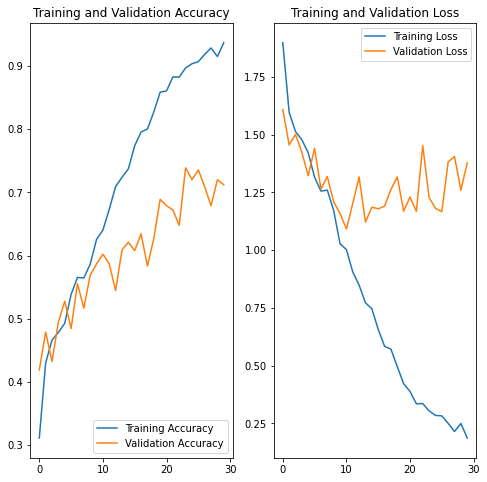

In [42]:
## Visualize the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

****Write your findings after the model fit, see if the issues are resolved or not?****

-  Accuracy on training data has increased by using Augmentor library.
-  Losses on training data has decresed by using Augmentor library.